In [ ]:
import pandas as pd
import numpy as np

# відфільтрувати дані
def filter_data(fname, price, quantity, invoice, stockcode):
    # Read data from both sheets into separate dataframes
    online_retail_sheet1 = pd.read_excel(fname, sheet_name='Year 2009-2010')
    online_retail_sheet2 = pd.read_excel(fname, sheet_name='Year 2010-2011')

    # Concatenate both dataframes vertically
    online_retail = pd.concat([online_retail_sheet1, online_retail_sheet2], ignore_index=True)

    # filter data
    online_retail = online_retail[(online_retail[price] > 0)
                                  & (online_retail[quantity] > 0)
                                  & (online_retail[quantity] < 1000)]
     #check the data in 'InvoiceNo'
    online_retail[invoice] = pd.to_numeric(online_retail[invoice], errors='coerce')

    # Drop rows where 'StockCode' contains 'POST'

    online_retail = online_retail[online_retail[stockcode] != 'POST']
    # delete duplicates and empty columns
    online_retail = online_retail.drop_duplicates().dropna()

    return online_retail

file_path = '/content/drive/MyDrive/online_retail_2.xlsx'
output = filter_data(file_path, "Price", "Quantity", "Invoice", "StockCode")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('dark_background')

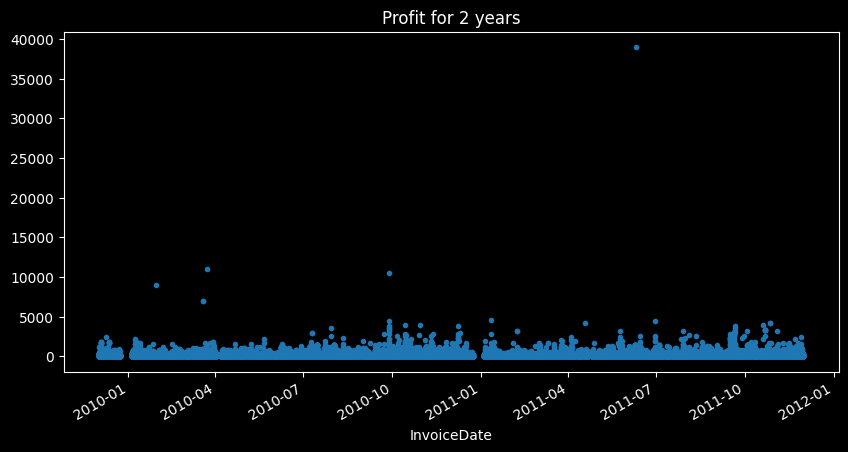

In [ ]:
output['InvoiceDate'] = pd.to_datetime(output['InvoiceDate'], format='%d.%m.%Y %H:%M:%S')
# без останнього місяця
online_retail_filtered = output[~((output['InvoiceDate'].dt.year == 2011) & (output['InvoiceDate'].dt.month == 12))]

# усі дані
df_main = output[['InvoiceDate', 'Price', 'Quantity', 'Country', 'Customer ID', 'Invoice', 'StockCode', 'Description']].copy()
df_main['PriceQ'] = df_main['Price'] * df_main['Quantity']
#df_main = df_main.drop(['Price', 'Quantity'], axis=1)

df_main = df_main.set_index('InvoiceDate')
df_main.index = pd.to_datetime(df_main.index)

# дата і ціна без останнього місяці
df_train = online_retail_filtered[['InvoiceDate', 'Price', 'Quantity', 'Country', 'Customer ID', 'Invoice', 'StockCode', 'Description']].copy()
df_train['PriceQ'] = df_train['Price'] * df_train['Quantity']
#df_train = df_train.drop(['Price', 'Quantity'], axis=1)

df_train = df_train.set_index('InvoiceDate')
df_train.index = pd.to_datetime(df_train.index)
df_train['PriceQ'].plot(style='.',
        figsize=(10, 5),
        color=color_pal[0],
        title='Profit for 2 years')
plt.show()

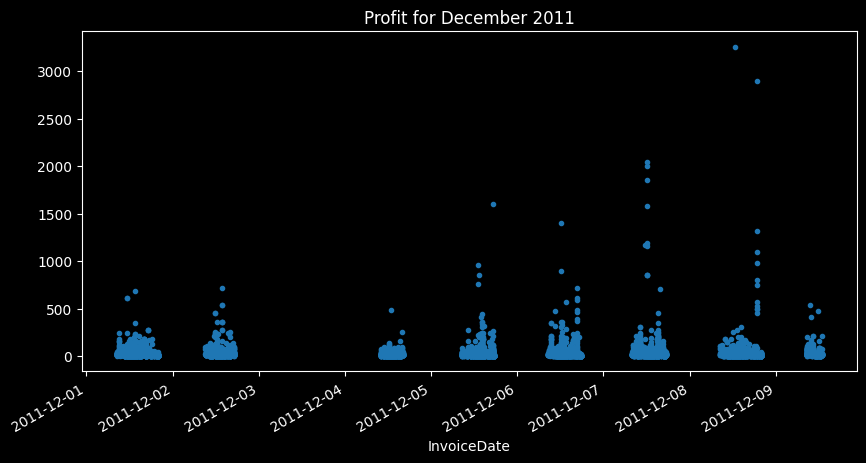

In [ ]:
data_dec_2011 = output[(output['InvoiceDate'].dt.year == 2011) & (output['InvoiceDate'].dt.month == 12)]

# дата і ціна останнього місяця
df_test = data_dec_2011[['InvoiceDate', 'Price', 'Quantity', 'Country', 'Customer ID', 'Invoice', 'StockCode', 'Description']].copy()
df_test['PriceQ'] = df_test['Price'] * df_test['Quantity']
#df_test = df_test.drop(['Price', 'Quantity'], axis=1)

df_test = df_test.set_index('InvoiceDate')
df_test.index = pd.to_datetime(df_test.index)
df_test['PriceQ'].plot(style='.',
        figsize=(10, 5),
        color=color_pal[0],
        title='Profit for December 2011')
plt.show()

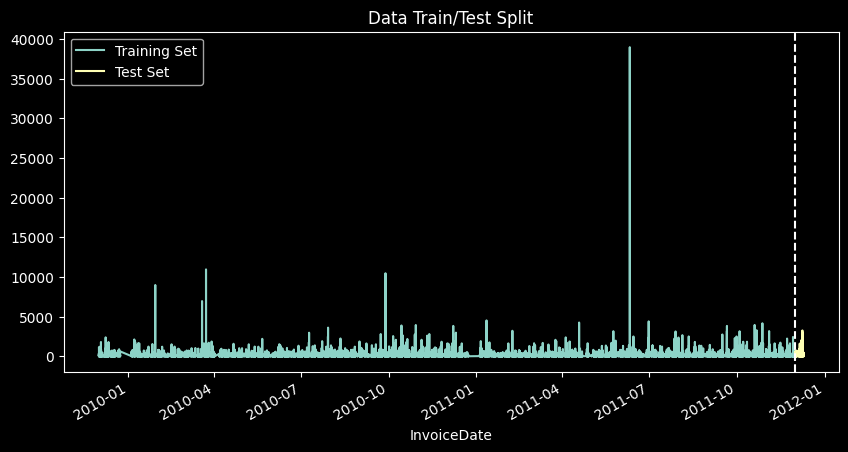

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_train['PriceQ'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
df_test['PriceQ'].plot(ax=ax, label='Test Set')
ax.axvline('12.01.2011', color='white', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

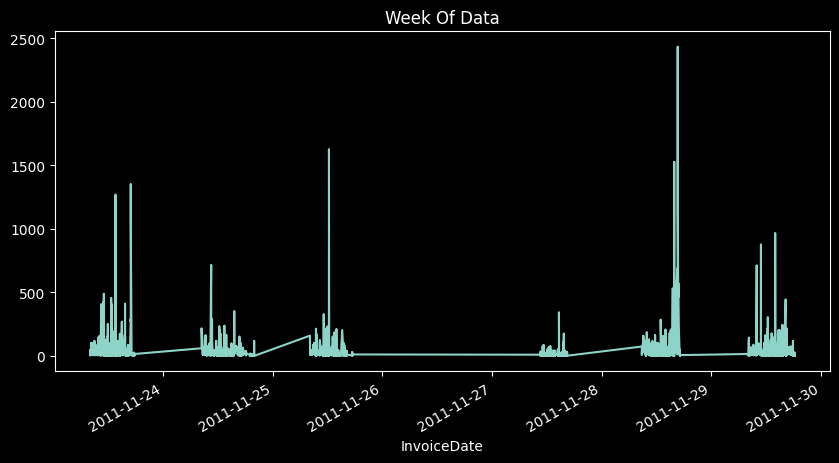

In [ ]:
df_train['PriceQ'].loc[(df_train.index >= '11.23.2011') & (df_train.index <= '11.30.2011')] \
    .plot(figsize=(10, 5), title='Week Of Data')
plt.show()

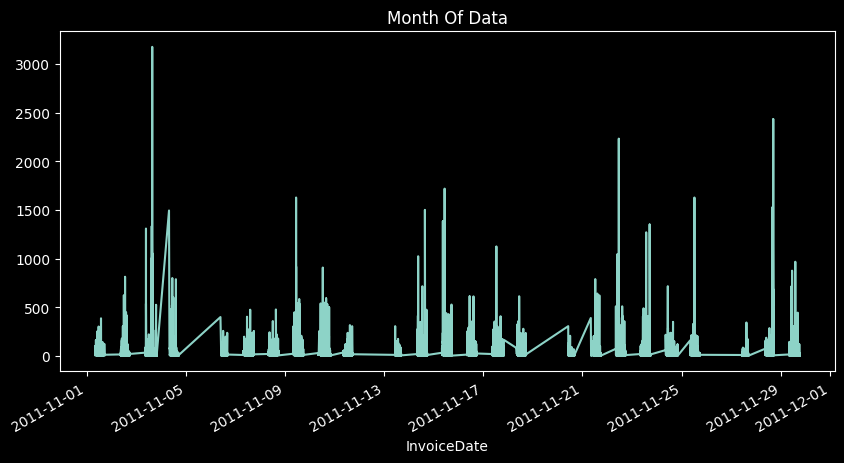

In [ ]:
df_train['PriceQ'].loc[(df_train.index >= '11.01.2011') & (df_train.index <= '11.30.2011')] \
    .plot(figsize=(10, 5), title='Month Of Data')
plt.show()

In [ ]:
from datetime import date
import holidays

def get_season(month):
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return "Winter"

def create_features(df):
  df = df.copy()

  calendars = {
        'United Kingdom': holidays.UnitedKingdom(),
        'United States': holidays.UnitedStates(),
        'USA': holidays.UnitedStates(),
        'France': holidays.France(),
        'Belgium': holidays.Belgium(),
        'Australia': holidays.Australia(),
        'Ireland': holidays.Ireland(),
        'EIRE': holidays.Ireland(),
        'Germany': holidays.Germany(),
        'Portugal': holidays.Portugal(),
        'Netherlands': holidays.Netherlands(),
        'Poland': holidays.Poland(),
        'Spain': holidays.Spain(),
        'Italy': holidays.Italy(),
        'Greece': holidays.Greece(),
        'Norway': holidays.Norway(),
        'Austria': holidays.Austria(),
        'Canada': holidays.Canada(),
        'Brazil': holidays.Brazil(),
        'Denmark': holidays.Denmark(),
        'Finland': holidays.Finland(),
        'Hong Kong': holidays.HongKong(),
        'Iceland': holidays.Iceland(),
        'South Korea': holidays.SouthKorea()
    }

  def is_holiday(row):
    country = row['Country']
    cal = calendars.get(country)
    if cal:
      return cal.is_holiday(row.name)
    else:
      return False

  df['is_holiday'] = df.apply(is_holiday, axis=1)

  purchase_count = df.groupby('Customer ID')['Quantity'].nunique()
  df['purchase_count'] = df['Customer ID'].map(purchase_count)

  # Додайте код для розрахунку середнього чека користувача
  average_spending = df.groupby('Customer ID')['PriceQ'].mean()
  df['average_spending'] = df['Customer ID'].map(average_spending)

  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['dayofmonth'] = df.index.day
  df['weekofmonth'] = df.index.isocalendar().week
  df['month'] = df.index.month
  df['quarter'] = df.index.quarter
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['weekofyear'] = df.index.isocalendar().week

  # розрахунки нових ознак:
  df['unique_products_count'] = df.groupby('Invoice')['StockCode'].transform('nunique')
  df['transaction_total'] = df.groupby('Invoice')['PriceQ'].transform('sum')
  df['unique_products_per_customer'] = df.groupby('Customer ID')['StockCode'].transform('nunique')
  df['avg_price_per_transaction'] = df.groupby('Invoice')['PriceQ'].transform('mean')

  # Перетворення типу даних UInt32 на int
  df['weekofmonth'] = df['weekofmonth'].astype(int)
  df['weekofyear'] = df['weekofyear'].astype(int)

  # ознак сезонності
  df['month'] = df.index.month
  df['season'] = df['month'].apply(get_season)

  # бінарних ознак для сезонів
  df = pd.get_dummies(df, columns=['season'], prefix='is')

  # ознаки для робочих та вихідних днів
  df['is_weekend'] = df['dayofweek'].apply(lambda day: 1 if day >= 5 else 0)


  return df


In [ ]:
train = create_features(df_train)

In [ ]:
test = create_features(df_test)

In [ ]:
#FEATURES = ['hour', 'dayofweek', 'dayofmonth', 'weekofmonth', 'month', 'quarter', 'year', 'dayofyear', 'weekofyear', 'is_holiday', 'purchase_count', 'average_spending']

FEATURES = ['Price', 'Quantity', 'Customer ID', 'Invoice', 'is_holiday', 'purchase_count', 'average_spending',
            'hour', 'dayofweek', 'dayofmonth', 'weekofmonth', 'month', 'quarter', 'year', 'dayofyear',
            'weekofyear', 'unique_products_count', 'transaction_total', 'unique_products_per_customer',
            'avg_price_per_transaction', 'is_Winter', 'is_weekend']

TARGET = 'PriceQ'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=100,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:81.59883	validation_1-rmse:67.52952
[50]	validation_0-rmse:57.64072	validation_1-rmse:49.34450
[100]	validation_0-rmse:42.00008	validation_1-rmse:37.76589
[150]	validation_0-rmse:31.38125	validation_1-rmse:30.33957
[200]	validation_0-rmse:24.02113	validation_1-rmse:25.36931
[250]	validation_0-rmse:18.91227	validation_1-rmse:22.29813
[300]	validation_0-rmse:15.27964	validation_1-rmse:19.12878
[350]	validation_0-rmse:12.74865	validation_1-rmse:16.84803
[400]	validation_0-rmse:10.84544	validation_1-rmse:15.13547
[450]	validation_0-rmse:9.35608	validation_1-rmse:13.89003
[500]	validation_0-rmse:8.14417	validation_1-rmse:12.84874
[550]	validation_0-rmse:7.19114	validation_1-rmse:12.18937
[600]	validation_0-rmse:6.43326	validation_1-rmse:11.75423
[650]	validation_0-rmse:5.84019	validation_1-rmse:11.42665
[700]	validation_0-rmse:5.38053	validation_1-rmse:11.08177
[750]	validation_0-rmse:5.00014	validation_1-rmse:10.73585
[800]	validation_0-rmse:4.68184	validation_1-rmse:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

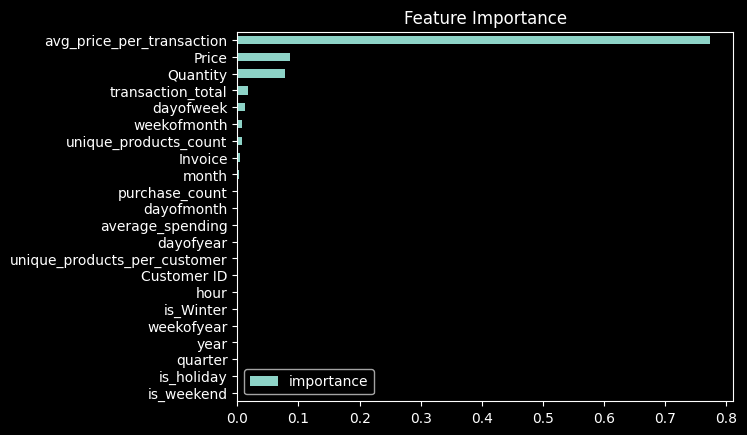

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

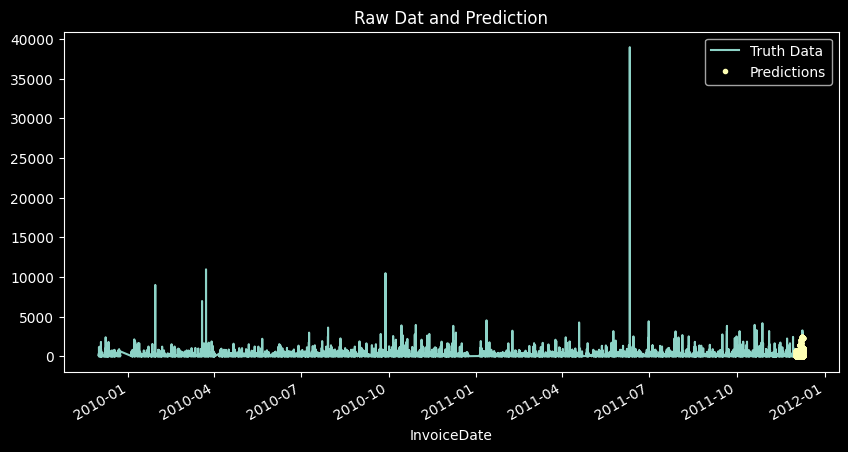

In [ ]:
test['prediction'] = reg.predict(X_test)
df_main = df_main.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_main[['PriceQ']].plot(figsize=(10, 5))
df_main['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

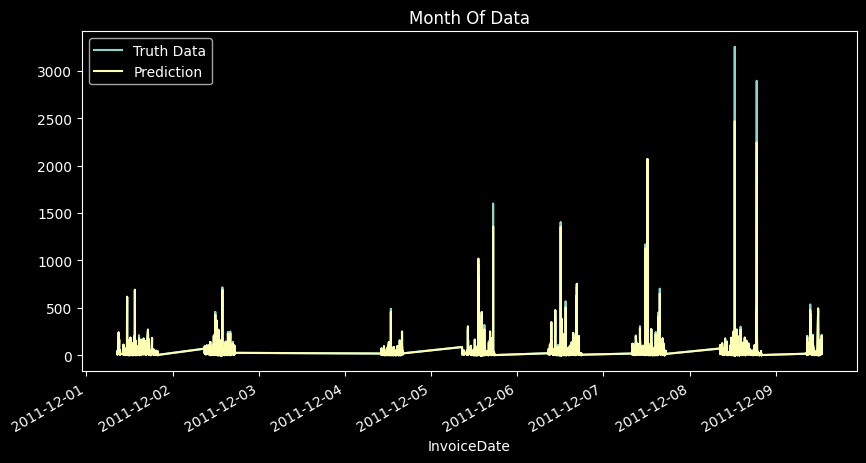

In [ ]:
ax = df_main.loc[(df_main.index >= '12.01.2011') & (df_main.index <= '12.31.2011')]['PriceQ'] \
    .plot(figsize=(10, 5), title='Month Of Data')
df_main.loc[(df_main.index >= '12.01.2011') & (df_main.index <= '12.30.2011')]['prediction'] \
    .plot(style='-')
plt.legend(['Truth Data','Prediction'])
plt.show()

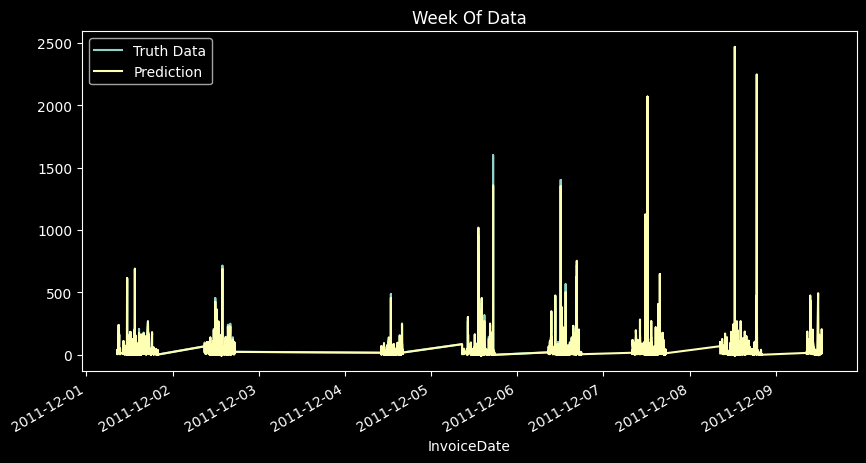

In [ ]:
ax = df_main.loc[(df_main.index >= '12.01.2011') & (df_main.index <= '12.07.2011')]['PriceQ'] \
    .plot(figsize=(10, 5), title='Week Of Data')
df_main.loc[(df_main.index >= '12.01.2011') & (df_main.index <= '12.30.2011')]['prediction'] \
    .plot(style='-')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['PriceQ'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 9.51


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2011-12-08    2.126308
2011-12-07    2.105869
2011-12-09    1.695968
2011-12-05    1.631809
2011-12-06    1.322460
Name: error, dtype: float64